In [5]:
import pandas as pd
from deap import base, creator, tools, algorithms
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt


In [8]:

# Load the dataset

df = pd.read_excel(r"customer_churn_dataset.xlsx")
df


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,StreamingTV,MonthlyCharges,TotalCharges,Churn
0,C001,Male,0,Yes,No,5,Yes,DSL,No,29.85,149.25,No
1,C002,Female,1,No,No,42,Yes,Fiber optic,Yes,56.95,2345.60,Yes
2,C003,Female,0,Yes,Yes,2,No,DSL,No,53.85,108.15,No
3,C004,Male,0,No,No,8,Yes,Fiber optic,Yes,42.30,338.40,No
4,C005,Female,1,Yes,Yes,22,Yes,DSL,Yes,70.70,1555.40,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
2084,C2085,Female,1,No,Yes,41,No,No,No,36.93,1514.13,No
2085,C2086,Female,1,No,No,47,No,No,No,21.10,991.70,Yes
2086,C2087,Male,1,Yes,No,15,Yes,No,No,84.73,1270.95,Yes
2087,C2088,Male,0,No,Yes,57,No,DSL,No,119.16,6792.12,No


In [161]:
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2089 entries, 0 to 2088
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerID       2089 non-null   object 
 1   gender           2089 non-null   object 
 2   SeniorCitizen    2089 non-null   int64  
 3   Partner          2089 non-null   object 
 4   Dependents       2089 non-null   object 
 5   tenure           2089 non-null   int64  
 6   PhoneService     2089 non-null   object 
 7   InternetService  2089 non-null   object 
 8   StreamingTV      2089 non-null   object 
 9   MonthlyCharges   2089 non-null   float64
 10  TotalCharges     2089 non-null   float64
 11  Churn            2089 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 196.0+ KB
None
       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    2089.000000  2089.000000     2089.000000   2089.000000
mean        0.502633    36.266156       69.976577   

In [ ]:
df.isnull().sum()

In [163]:
df.drop_duplicates(inplace=True)

In [ ]:

le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender']) 
df['Partner'] = le.fit_transform(df['Partner']) 
df['Dependents'] = le.fit_transform(df['Dependents']) 
df['PhoneService'] = le.fit_transform(df['PhoneService'])  
df['StreamingTV'] = le.fit_transform(df['StreamingTV'])  
df['Churn'] = le.fit_transform(df['Churn'])  
df['InternetService'] = le.fit_transform(df['InternetService']) 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,StreamingTV,MonthlyCharges,TotalCharges,Churn
0,C001,1,0,1,0,5,1,0,0,29.85,149.25,0
1,C002,0,1,0,0,42,1,1,1,56.95,2345.60,1
2,C003,0,0,1,1,2,0,0,0,53.85,108.15,0
3,C004,1,0,0,0,8,1,1,1,42.30,338.40,0
4,C005,0,1,1,1,22,1,0,1,70.70,1555.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2084,C2085,0,1,0,1,41,0,2,0,36.93,1514.13,0
2085,C2086,0,1,0,0,47,0,2,0,21.10,991.70,1
2086,C2087,1,1,1,0,15,1,2,0,84.73,1270.95,1
2087,C2088,1,0,0,1,57,0,0,0,119.16,6792.12,0


In [ ]:

churn_yes_df = df[df['Churn'] == 1]
churn_no_df = df[df['Churn'] == 0]
min_class_size = min(len(churn_yes_df), len(churn_no_df))
churn_yes_balanced = churn_yes_df.sample(n=min_class_size, random_state=42)
churn_no_balanced = churn_no_df.sample(n=min_class_size, random_state=42)
df_balanced = pd.concat([churn_yes_balanced, churn_no_balanced]).sample(frac=1, random_state=42)
print(df_balanced['Churn'].value_counts())

Churn
0    1042
1    1042
Name: count, dtype: int64


In [ ]:

X = df_balanced.drop(['customerID', 'Churn'], axis=1)
y = df_balanced['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [167]:

creator.create("FitnessMax", base.Fitness, weights=(1.0,))  
creator.create("Individual", list, fitness=creator.FitnessMax)

def create_individual():
    return [random.randint(0, 1) for _ in range(X_train.shape[1])]

def evaluate(individual):
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    
    if len(selected_features) == 0:
        return (0,)  

    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return (accuracy,)  


c:\Users\Mega Store\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\Mega Store\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [168]:

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

population = toolbox.population(n=50)

algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=20, 
                    stats=None, halloffame=None, verbose=True)

best_individual = tools.selBest(population, 1)[0]


selected_features = [i for i in range(len(best_individual)) if best_individual[i] == 1]


gen	nevals
0  	50    
1  	31    
2  	30    
3  	36    
4  	30    
5  	43    
6  	32    
7  	42    
8  	35    
9  	40    
10 	31    
11 	37    
12 	38    
13 	39    
14 	33    
15 	43    
16 	35    
17 	38    
18 	43    
19 	30    
20 	35    


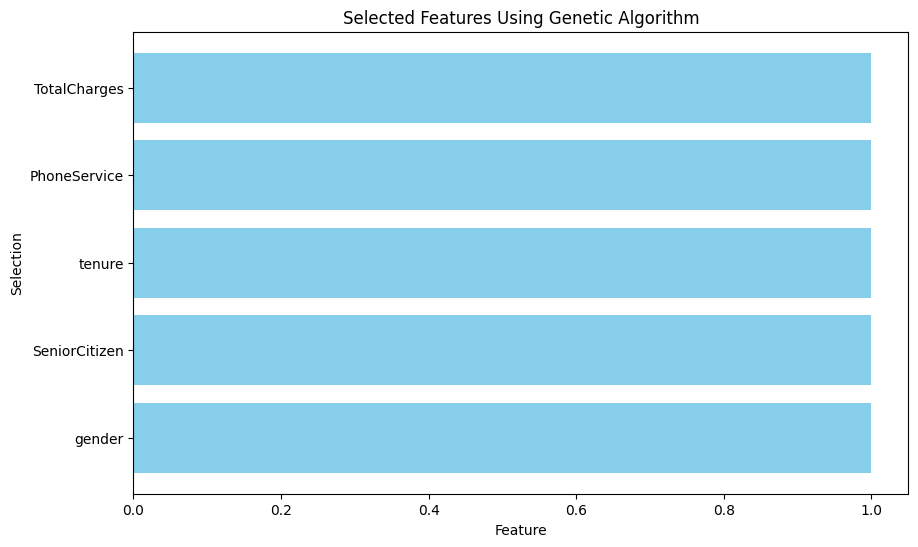

In [169]:


plt.figure(figsize=(10, 6))
feature_names = X.columns[selected_features]
plt.barh(feature_names, [1] * len(feature_names), color='skyblue')
plt.title('Selected Features Using Genetic Algorithm')
plt.xlabel('Feature')
plt.ylabel('Selection')
plt.show()


In [ ]:

X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]
model = RandomForestClassifier(random_state=42)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)



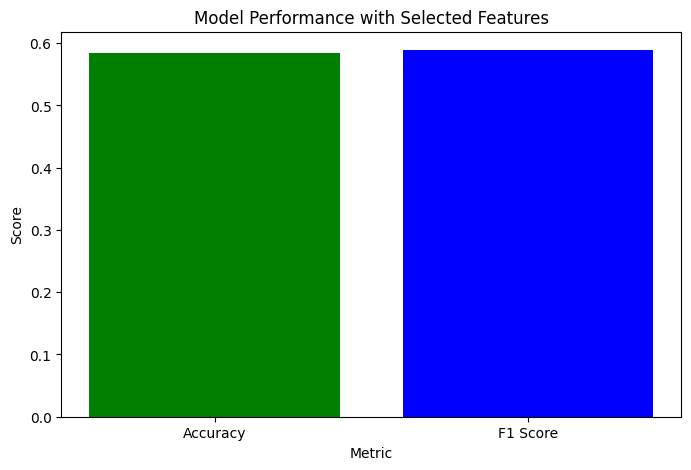

Accuracy of the model with selected features: 0.5851318944844125
F1 score of the model with selected features: 0.5890736342042755


In [ ]:

performance = {'Accuracy': accuracy, 'F1 Score': f1}
plt.figure(figsize=(8, 5))
plt.bar(performance.keys(), performance.values(), color=['green', 'blue'])
plt.title('Model Performance with Selected Features')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.show()
print("Accuracy of the model with selected features:", accuracy)
print("F1 score of the model with selected features:", f1)
